# Word Embeddings

Apply functions from the practical classes notebooks, in order to compare the results with the baseline classification

## Word2Vec in Gensim

[Word2Vec](https://code.google.com/archive/p/word2vec/) is a model for training word embeddings that revolutionized the way words are represented. [Gensim](https://radimrehurek.com/gensim_3.8.3/models/word2vec.html) provides an implementation of the algorithm, with which we can train our own word embeddings.

In [1]:
from gensim.models import Word2Vec, KeyedVectors

## Article's body

Our first task is to create a model based on the article's body, hoping that it is easier to predict the labels on a corpus with the same thematics

In [2]:
import pandas as pd

articles = pd.read_excel("./data/OpArticles.xlsx")

In [3]:
import re

documents = []
for i in range(0, articles['body'].size):
    # get review, remove non alpha chars and convert to lower-case
    review = re.sub('[^a-zA-Z\u00C0-\u00ff]', ' ', articles['body'][i]).lower()
    # add review to corpus
    documents.append(review.split())

#### Training the Word2Vec model

In [4]:
from time import time

start_time = time()
model_articles = Word2Vec(documents, vector_size=150, window=10, min_count=2, workers=10, sg=1)

print("Training time:", time() - start_time)

Training time: 5.063976764678955


In [5]:
model_articles.wv.save("./word_vectors/wv_articles")

In [6]:
model_articles = KeyedVectors.load("./word_vectors/wv_articles")

## Portuguese embeddings

A number of embeddings for Portuguese are available at [NILC](http://nilc.icmc.usp.br/embeddings), as well as at the [NLX-group](https://github.com/nlx-group/LX-DSemVectors).

We will be testing the following models from NILC
- Word2Vec CBOW 100 dimensions
- Word2Vec SKIP-GRAM 100 dimensions
- FastText CBOW 100 dimensions
- FastText SKIP-GRAM 100 dimensions
- FastText SKIP-GRAM 1000 dimensions

Only need to load from .txt once, then load only created word vectors

In [7]:
# takes a while to load...
model_w2v_cbow_s100 = KeyedVectors.load_word2vec_format('./word_vectors/w2v_cbow_s100.txt')
# save model word vectors
model_w2v_cbow_s100.save("./word_vectors/wv_w2v_cbow_s100")

In [8]:
model_w2v_skip_s100 = KeyedVectors.load_word2vec_format('./word_vectors/w2v_skip_s100.txt')
model_w2v_skip_s100.save("./word_vectors/wv_w2v_skip_s100")

In [9]:
model_ft_cbow_s100 = KeyedVectors.load_word2vec_format('./word_vectors/ft_cbow_s100.txt')
model_ft_cbow_s100.save("./word_vectors/wv_ft_cbow_s100")

In [10]:
model_ft_skip_s100 = KeyedVectors.load_word2vec_format('./word_vectors/ft_skip_s100.txt')
model_ft_skip_s100.save("./word_vectors/wv_ft_skip_s100")

In [11]:
model_ft_skip_s1000 = KeyedVectors.load_word2vec_format('./word_vectors/ft_skip_s1000.txt')
model_ft_skip_s1000.save("./word_vectors/wv_ft_skip_s1000")

Load model word vectors (much faster than the above)

In [7]:
model_w2v_cbow_s100 = KeyedVectors.load("./word_vectors/wv_w2v_cbow_s100")

In [8]:
model_w2v_skip_s100 = KeyedVectors.load("./word_vectors/wv_w2v_skip_s100")

In [9]:
model_ft_cbow_s100 = KeyedVectors.load("./word_vectors/wv_ft_cbow_s100")

In [10]:
model_ft_skip_s100 = KeyedVectors.load("./word_vectors/wv_ft_skip_s100")

In [11]:
model_ft_skip_s1000 = KeyedVectors.load("./word_vectors/wv_ft_skip_s1000")

## Load Dataset

In [12]:
dataset = pd.read_excel('OpArticles_ADUs.xlsx')

#### Cleanup

In [13]:
corpus = []
for i in range(0, dataset['tokens'].size):
    # get review, remove non alpha chars and convert to lower-case
    review = re.sub('[^a-zA-Z\u00C0-\u00ff]', ' ', dataset['tokens'][i]).lower()
    # add review to corpus
    corpus.append(review)

#### Fixing the length of the input

The reviews in our corpus have variable length. However, we need to represent them with a fixed-length vector of features. One way to do it is to impose a limit on the number of word embeddings we want to include.

To convert words into their vector representations (embeddings), let's create an auxiliary function that takes in the number of embeddings we wish to include in the representation:

In [14]:
import numpy as np

def text_to_vector(embeddings, text, sequence_len):
    
    # split text into tokens
    tokens = text.split()
    
    # convert tokens to embedding vectors, up to sequence_len tokens
    vec = []
    n = 0
    i = 0
    while i < len(tokens) and n < sequence_len:   # while there are tokens and did not reach desired sequence length
        try:
            vec.extend(embeddings.get_vector(tokens[i]))
            n += 1
        except KeyError:
            True   # simply ignore out-of-vocabulary tokens
        finally:
            i += 1
    
    # add blanks up to sequence_len, if needed
    for j in range(sequence_len - n):
        vec.extend(np.zeros(embeddings.vector_size,))
    
    return vec

The above *text_to_vector* function takes an *embeddings* dictionary, the *text* to convert, and the number of words *sequence_len* from *text* to consider. It returns a vector with appended embeddings for the first *sequence_len* words that exist in the *embeddings* dictionary (tokens for which no embedding is found are ignored). In case the text has less than *sequence_len* words for which we have embeddings, blank embeddings will be added.

To better decide how many word embeddings we wish to append, let's learn a bit more about the length of each review in our corpus.

In [15]:
from scipy import stats

lens = [len(c.split()) for c in corpus]
print(np.min(lens), np.max(lens), np.mean(lens), np.std(lens), stats.mode(lens))

1 82 14.30406737143881 9.470560303048728 ModeResult(mode=array([8]), count=array([972]))


## Predictions

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [17]:
def predict(model):
    # convert corpus into dataset with appended embeddings representation
    embeddings_corpus = []
    for c in corpus:
        embeddings_corpus.append(text_to_vector(model, c, 15))

    X = np.array(embeddings_corpus)
    y = dataset['label']

    print(X.shape, y.shape)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, stratify=y)

    clf = SGDClassifier(random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print("Classification report:\n", classification_report(y_test, y_pred))
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, labels=clf.classes_), display_labels=clf.classes_).plot()

### Article's body model

(16743, 2250) (16743,)
Classification report:
               precision    recall  f1-score   support

        Fact       0.44      0.06      0.11       733
      Policy       0.56      0.07      0.12       133
       Value       0.50      0.98      0.66      1621
    Value(+)       0.08      0.00      0.01       282
    Value(-)       0.44      0.01      0.03       580

    accuracy                           0.49      3349
   macro avg       0.40      0.23      0.18      3349
weighted avg       0.44      0.49      0.35      3349



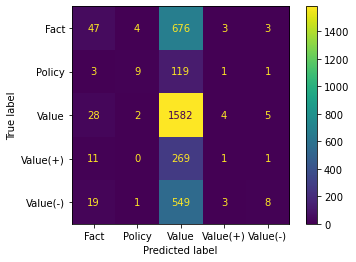

In [18]:
predict(model_articles)

### NILC PT Models

(16743, 1500) (16743,)
Classification report:
               precision    recall  f1-score   support

        Fact       0.40      0.35      0.38       733
      Policy       0.40      0.32      0.35       133
       Value       0.55      0.69      0.61      1621
    Value(+)       0.29      0.16      0.21       282
    Value(-)       0.38      0.28      0.32       580

    accuracy                           0.48      3349
   macro avg       0.41      0.36      0.37      3349
weighted avg       0.46      0.48      0.47      3349



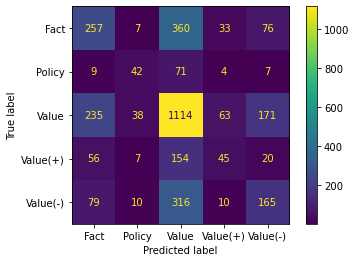

In [19]:
predict(model_w2v_cbow_s100)

(16743, 1500) (16743,)
Classification report:
               precision    recall  f1-score   support

        Fact       0.41      0.34      0.37       733
      Policy       0.40      0.35      0.37       133
       Value       0.55      0.67      0.61      1621
    Value(+)       0.27      0.19      0.22       282
    Value(-)       0.35      0.27      0.30       580

    accuracy                           0.48      3349
   macro avg       0.40      0.36      0.38      3349
weighted avg       0.46      0.48      0.46      3349



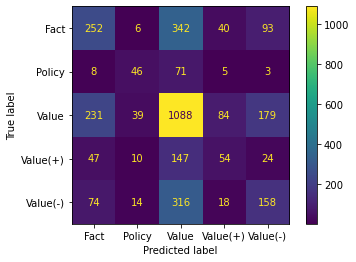

In [20]:
predict(model_w2v_skip_s100)

(16743, 1500) (16743,)
Classification report:
               precision    recall  f1-score   support

        Fact       0.33      0.38      0.35       733
      Policy       0.41      0.40      0.40       133
       Value       0.57      0.41      0.48      1621
    Value(+)       0.27      0.27      0.27       282
    Value(-)       0.28      0.46      0.35       580

    accuracy                           0.40      3349
   macro avg       0.37      0.38      0.37      3349
weighted avg       0.44      0.40      0.41      3349



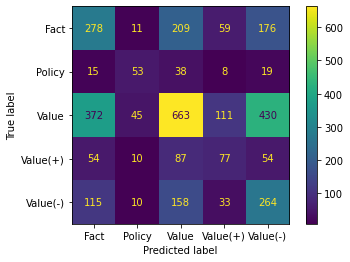

In [21]:
predict(model_ft_cbow_s100)

(16743, 1500) (16743,)
Classification report:
               precision    recall  f1-score   support

        Fact       0.45      0.38      0.41       733
      Policy       0.55      0.29      0.38       133
       Value       0.56      0.61      0.59      1621
    Value(+)       0.26      0.29      0.27       282
    Value(-)       0.38      0.38      0.38       580

    accuracy                           0.48      3349
   macro avg       0.44      0.39      0.41      3349
weighted avg       0.48      0.48      0.48      3349



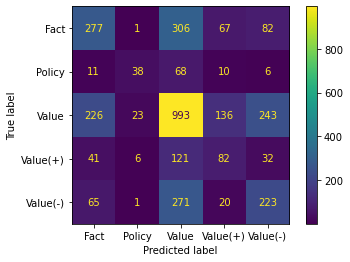

In [22]:
predict(model_ft_skip_s100)

(16743, 15000) (16743,)
Classification report:
               precision    recall  f1-score   support

        Fact       0.42      0.41      0.41       733
      Policy       0.71      0.45      0.55       133
       Value       0.59      0.59      0.59      1621
    Value(+)       0.41      0.38      0.39       282
    Value(-)       0.42      0.49      0.45       580

    accuracy                           0.51      3349
   macro avg       0.51      0.46      0.48      3349
weighted avg       0.51      0.51      0.51      3349



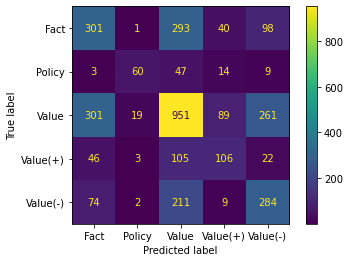

In [23]:
predict(model_ft_skip_s1000)